# IberLEF - HOMO-LAT25
---

In [144]:
import torch
import torch.nn as nn

from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, AutoModel, AutoConfig
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ast

In [145]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

Device count: 1
Current device: 0
NVIDIA GeForce RTX 3090


In [146]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [147]:
# Parameters
NUM_CLASSES = 3
MODELS_PATH = "../checkpoints/"

# Model Hyperparameters
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-5
WARMUP_STEPS = 0
WEIGHT_DECAY = 0.01

In [148]:
# ENG
paraphrase_col = "paraphrase"
text_col = "translation"

# ESP
# paraphrase_col = "paraphrase_esp"
# text_col = "post content"

In [149]:
# MODEL_NAME = "google-bert/bert-base-uncased"
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
# MODEL_NAME = "FacebookAI/roberta-base"
# MODEL_NAME = "tabularisai/multilingual-sentiment-analysis"
# MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
# MODEL_NAME = "google-bert/bert-base-multilingual-uncased"
# MODEL_NAME = "JonatanGk/roberta-base-bne-finetuned-hate-speech-offensive-spanish"
# MODEL_NAME = "pysentimiento/robertuito-sentiment-analysis"

id2label = {0: 'NEG', 1: 'NEU', 2: 'POS'}

label2id = {'NEG': 0, 'NEU': 1, 'POS': 2}

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES, id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [150]:
model.config

RobertaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [151]:
class CustomBERTModel(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name, num_labels=num_labels)
        self.feedforward = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.bert.config.hidden_size // 2, self.bert.config.hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(self.bert.config.hidden_size // 4, num_labels)

    def forward(self, input_ids, attention_mask, labels=None, token_type_ids=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Get the last hidden state
        last_hidden_state = output.last_hidden_state
        # Use the CLS token representation (first token)
        cls_token = last_hidden_state[:, 0, :]
        # Pass through feedforward layers
        x = self.feedforward(cls_token)
        # Final classification layer
        logits = self.fc(x)
        return logits

In [152]:
# model = CustomBERTModel(MODEL_NAME, NUM_CLASSES)
# model.to(device)

### Tokenizer

In [153]:
print("Max sequence length:", tokenizer.model_max_length)
tokenizer.model_max_length = MAX_LEN
print("Max sequence length:", tokenizer.model_max_length)

Max sequence length: 1000000000000000019884624838656
Max sequence length: 256


In [154]:
# Print first 10 ids of tokenizer
print(tokenizer.convert_ids_to_tokens(range(10)))

['<s>', '<pad>', '</s>', '<unk>', '.', 'Ġthe', ',', 'Ġto', 'Ġand', 'Ġof']


### Load datasets

In [155]:
data_path = "../data/"
train_path = data_path + "train_paraphrased.csv"
val_path = data_path + "val_paraphrased.csv"
test_path = data_path + "test_paraphrased.csv"
dev_path = data_path + "dev_paraphrased.csv"

In [156]:
data = pd.read_csv(data_path + "data.csv", index_col=0)

In [157]:
# train_df = pd.read_csv(train_path)
# val_df = pd.read_csv(val_path)
# test_df = pd.read_csv(test_path)
# dev_df = pd.read_csv(dev_path)


# columns = ['country', 'keyword', 'post content', 'label', 'embeddings',
#        'translation', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase',
#        'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2',
#        'embedding_paraphrase_esp1', 'embedding_paraphrase_esp2']

# # Create columns if they don't exist
# for col in columns:
#     if col not in train_df.columns:
#         train_df[col] = None
#     if col not in val_df.columns:
#         val_df[col] = None
#     if col not in test_df.columns:
#         test_df[col] = None
#     if col not in dev_df.columns:
#         dev_df[col] = None

# # Order dataframe columns
# train_df = train_df[columns]
# val_df = val_df[columns]
# test_df = test_df[columns]
# dev_df = dev_df[columns]

# print(train_df.columns)
# print(val_df.columns)
# print(test_df.columns)
# print(dev_df.columns)

In [158]:
# # Join all dataframes
# data = pd.concat([train_df, val_df, test_df, dev_df], ignore_index=True)
# data.shape

In [159]:
data.head()

,keyword,post content,label,embeddings,translation,embeddings_ingles,absa,absa_esp,paraphrase,paraphrase_esp,embedding_paraphrase1,embedding_paraphrase2,embedding_paraphrase_esp1,embedding_paraphrase_esp2,country
Argentina,trans,ni idea quin es yo conozco a elon muse que es ...,1,[ 1.03526646e-02 -3.98133248e-02 4.34677452e-...,no idea who that is i know elon muse who is a ...,[-6.73531964e-02 -7.03806058e-02 3.57527845e-...,[CLS] no idea who that is i know elon muse who...,[CLS] ni idea quin es yo conozco a elon muse q...,"['I have no clue who that is, but I know Elon ...","['No tengo ni la menor idea de quién es, pero ...",[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
Argentina,gay,quise decir que generaciones no tan viejas est...,0,[ 1.48003269e-02 1.87553223e-02 -4.54413369e-...,i meant to say that generations not so old are...,[ 8.76692608e-02 1.54911121e-02 -6.65056929e-...,[CLS] i meant to say that generations not so o...,[CLS] quise decir que generaciones no tan viej...,"[""I was trying to convey that not-so-old gener...",['Lo que quiero expresar es que hay generacion...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-4.96738590e-02 8.76008645e-02 9.10560042e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
Argentina,transgénero,somos una pareja trans tenemos una relacin pol...,1,[ 6.02439139e-03 -4.05745283e-02 3.04297004e-...,we are a trans couple we have a polyamorous an...,[-1.39014676e-01 -3.52461934e-02 -6.17404003e-...,[CLS] we are a trans couple we have a polyamor...,[CLS] somos una pareja trans tenemos una relac...,"[""We are a trans couple with a polyamorous and...",['Somos una pareja transgénero y tenemos una r...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-4.96738590e-02 8.76008645e-02 9.10560042e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
Argentina,lesbiana,epidemia el caso de la lesbiana fumando fue ha...,1,[ 1.32222874e-02 -1.37489401e-02 4.94725667e-...,epidemic the case of the lesbian smoking was a...,[ 3.90458480e-02 6.92736730e-03 5.75472973e-...,[CLS] epidemic the case of the lesbian smoking...,[CLS] epidemia el caso de la lesbiana fumando ...,['epidemic the situation with the lesbian smok...,['la situación con la lesbiana fumando ocurrió...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
Argentina,trans,la joven y la trans seducian clientes y la git...,1,[ 0.00305685 -0.01683133 0.01658298 -0.002807...,the young woman and the trans seduced clients ...,[-5.73628880e-02 1.41364560e-01 -7.25603327e-...,[CLS] the young woman and the trans seduced cl...,[CLS] la joven y la trans seducian clientes y ...,['The young lady and the transgender person wo...,['la chica y la trans atraían a los clientes m...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN


In [160]:
data[paraphrase_col] = data[paraphrase_col].str.lower()
data[text_col] = data[text_col].str.lower()

In [161]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data['label'])
train_df, val_df = train_test_split(train_df, test_size=1/8, random_state=RANDOM_SEED, stratify=train_df['label'])

train_df.columns

Index(['keyword', 'post content', 'label', 'embeddings', 'translation',
       'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase', 'paraphrase_esp',
       'embedding_paraphrase1', 'embedding_paraphrase2',
       'embedding_paraphrase_esp1', 'embedding_paraphrase_esp2', 'country'],
      dtype='object')

In [162]:
# Reset all indices
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [163]:
import re
import html

def clean_reddit_text(text):
    """
    Clean and normalize Reddit post text for sentiment analysis
    """
    if not isinstance(text, str):
        return ""
    
    # Unescape HTML entities
    text = html.unescape(text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove subreddit references and user mentions
    text = re.sub(r'/?[ru]/[A-Za-z0-9_-]+', '', text)
    
    # Remove markdown formatting
    text = re.sub(r'\*\*|\*|~~|__|_|\[|\]|\(|\)|>', '', text)
    
    # Handle [deleted] and [removed]
    text = re.sub(r'\[deleted\]|\[removed\]', '', text)
    
    # Remove edit notes
    text = re.sub(r'edit\s*:', '', text, flags=re.IGNORECASE)
    
    # Clean up whitespace and newlines
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

In [164]:
train_df[paraphrase_col].head()

0    ['i\'ve started to believe that the rejection,...
1    ["it’s quite simple: if you notice those at th...
2    ['there are numerous transvestites from many y...
3    ['to the `transvestites`. i’m not sure if you’...
4    ['do you enjoy the penis as a guy? are you gay...
Name: paraphrase, dtype: object

In [165]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   keyword                    5044 non-null   object
 1   post content               5044 non-null   object
 2   label                      5044 non-null   int64 
 3   embeddings                 5044 non-null   object
 4   translation                5044 non-null   object
 5   embeddings_ingles          5044 non-null   object
 6   absa                       4055 non-null   object
 7   absa_esp                   4055 non-null   object
 8   paraphrase                 5044 non-null   object
 9   paraphrase_esp             5044 non-null   object
 10  embedding_paraphrase1      5044 non-null   object
 11  embedding_paraphrase2      5044 non-null   object
 12  embedding_paraphrase_esp1  5044 non-null   object
 13  embedding_paraphrase_esp2  5044 non-null   object
 14  country 

In [166]:
# Rename column 'translation' to 'text'
train_df = train_df.rename(columns={text_col: 'text'})
val_df = val_df.rename(columns={text_col: 'text'})
test_df = test_df.rename(columns={text_col: 'text'})

In [167]:
from DataAugDataset import DataAugDataset

# Create datasets
random_text = 1
random_remove = False
random_order = False
train_dataset = DataAugDataset(train_df["text"].values,
                               train_df[paraphrase_col].values, 
                               train_df["label"].values, 
                               tokenizer, 
                               MAX_LEN,
                               random_text=random_text,
                               random_remove=random_remove, 
                               random_order=random_order)

In [168]:
from datasets import Dataset, DatasetDict

raw_datasets = DatasetDict({
    # "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False),
})
raw_datasets

DatasetDict({
    validation: Dataset({
        features: ['keyword', 'post content', 'label', 'embeddings', 'text', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase', 'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2', 'embedding_paraphrase_esp1', 'embedding_paraphrase_esp2', 'country'],
        num_rows: 721
    })
    test: Dataset({
        features: ['keyword', 'post content', 'label', 'embeddings', 'text', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase', 'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2', 'embedding_paraphrase_esp1', 'embedding_paraphrase_esp2', 'country'],
        num_rows: 1442
    })
})

In [169]:
train_df["label"].value_counts()

label
1    2842
0    1703
2     499
Name: count, dtype: int64

In [170]:
val_df["label"].value_counts()

label
1    406
0    244
2     71
Name: count, dtype: int64

In [171]:
test_df["label"].value_counts()

label
1    812
0    487
2    143
Name: count, dtype: int64

In [172]:
from sklearn.utils.class_weight import compute_class_weight

train_labels = train_df["label"]
class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(class_weights)

tensor([0.9873, 0.5916, 3.3694], device='cuda:0')


In [173]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

# Apply the tokenizer to the dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Inspect tokenized samples
print(tokenized_datasets["validation"][0]["input_ids"])
# Ids to tokens
print(tokenizer.convert_ids_to_tokens(tokenized_datasets["validation"][0]["input_ids"]))

Map: 100%|██████████| 1442/1442 [00:00<00:00, 7106.58 examples/s]

[0, 179, 5, 78, 233, 47, 26, 89, 32, 8, 45, 14, 70, 50, 144, 32, 101, 14, 98, 939, 33, 1085, 7, 224, 59, 14, 233, 50140, 13, 1246, 13, 209, 82, 89, 32, 117, 604, 54, 101, 6907, 2498, 251, 2549, 2498, 7855, 14303, 50, 145, 7671, 7, 97, 604, 114, 41, 1736, 6616, 70, 167, 1274, 51, 33, 7, 28, 10, 693, 50140, 11, 754, 103, 9, 167, 54, 1763, 19, 6214, 13493, 5110, 9914, 1235, 25, 35262, 50118, 50118, 1594, 10, 313, 3829, 27360, 383, 34, 251, 2549, 15033, 7855, 8, 14442, 25, 10, 693, 53, 202, 18785, 25, 10, 313, 37, 115, 28, 1687, 10, 6214, 13493, 1459, 53, 47, 341, 5, 1385, 6214, 13493, 1459, 19, 6214, 390, 61, 16, 402, 430, 939, 206, 47, 241, 5, 65, 54, 34, 10, 936, 89, 30, 9397, 80, 430, 383, 8, 596, 16, 24, 3518, 7, 28, 10, 14752, 9, 28117, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [174]:
# Tokenize one paraphrase
inputs_ids = tokenizer(train_df[paraphrase_col][0], padding="max_length", truncation=True, max_length=MAX_LEN)["input_ids"]
print(tokenizer.convert_ids_to_tokens(inputs_ids))

['<s>', "['", 'i', "\\'", 've', 'Ġstarted', 'Ġto', 'Ġbelieve', 'Ġthat', 'Ġthe', 'Ġrejection', ',', 'Ġin', 'Ġterms', 'Ġof', 'Ġpreference', ',', 'Ġtowards', 'Ġtrans', 'Ġindividuals', 'Ġstems', 'Ġfrom', 'Ġthe', 'Ġ"', 'unc', 'anny', 'Ġvalley', ',"', 'Ġmaking', 'Ġit', 'Ġa', 'Ġsubconscious', 'Ġresponse', 'Ġthat', 'âĢ', 'Ļ', 's', 'Ġhard', 'Ġto', 'Ġarticulate', 'Ġbut', 'Ġnonetheless', 'Ġsignificant', 'Ġand', 'Ġinfluential', '.', 'Ġthis', 'Ġcompl', 'icates', 'Ġhow', 'Ġwe', 'Ġapproach', 'Ġthe', 'Ġtopic', '.', 'Ġregarding', 'Ġthe', 'Ġsubs', ',', 'Ġi', "\\'", 've', 'Ġnoticed', 'Ġthat', 'Ġa', 'Ġsignificant', 'Ġamount', 'Ġof', 'Ġmakeup', 'Ġis', 'Ġtypically', 'Ġapplied', 'Ġin', 'Ġthe', 'Ġfinal', 'Ġresults', ',', 'Ġand', 'Ġof', 'Ġcourse', ',', 'Ġmakeup', 'Ġcan', 'Ġbe', 'Ġincredibly', 'Ġtransformative', ',', 'Ġwhich', 'Ġprompts', 'Ġthe', 'Ġquestion', ':', 'Ġwhat', 'Ġdoes', 'Ġattractive', 'Ġeven', 'Ġmean', '?', 'Ġone', 'Ġpoint', 'Ġi', 'Ġneglected', 'Ġto', 'Ġmention', 'Ġis', 'Ġthat', 'Ġin', 'Ġthe', 'Ġima

In [175]:
# Remove unnecessary columns
rem_cols = ['country', 'keyword', 'post content', 'text', 'embeddings', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase', 'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2', 'embedding_paraphrase_esp2', 'embedding_paraphrase_esp1']
# tokenized_datasets = tokenized_datasets.remove_columns(rem_cols)
tokenized_datasets["validation"] = tokenized_datasets["validation"].remove_columns(rem_cols)
tokenized_datasets["test"] = tokenized_datasets["test"].remove_columns(rem_cols)
# Rename column 'label' to 'labels'
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets

DatasetDict({
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 721
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1442
    })
})

In [176]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator
)
val_dataloader = DataLoader(
    tokenized_datasets["validation"], shuffle=False, batch_size=BATCH_SIZE, collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_datasets["test"], shuffle=False, batch_size=BATCH_SIZE, collate_fn=data_collator
)

print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))
print("Test dataloader length:", len(test_dataloader))

Train dataloader length: 316
Validation dataloader length: 46
Test dataloader length: 91


In [177]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([16, 256]),
 'attention_mask': torch.Size([16, 256]),
 'labels': torch.Size([16])}

In [178]:
for param in model.parameters():
   param.requires_grad = True

# Freeze all layers except the classifier
# for param in list(model.parameters())[:-20]:
#     param.requires_grad = False

for param in model.parameters():
    print(param.requires_grad)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### Model without fine-tuning

In [179]:
model.eval()

threshold = 0.1

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        probs = nn.functional.softmax(logits, dim=-1)

        # # If NEU and NEG probabilities are both < threshold, classify as POS
        # pos_mask = (probs[:, 0] < threshold) & (probs[:, 1] < threshold)
        # pred = torch.full((probs.shape[0],), 2, dtype=torch.long, device=device)  # Default to POS class
        # pred[~pos_mask] = torch.argmax(probs[~pos_mask], dim=1)


        # Classify as POS if positive probability > threshold
        pred = torch.full((probs.shape[0],), 0, dtype=torch.long, device=device)  # Default to initial class
        pos_mask = probs[:, 2] > threshold  # Assuming POS is the third class (index 2)
        pred[pos_mask] = 2  # Set to POS class
        
        # For remaining samples, use argmax
        non_pos_mask = ~pos_mask
        pred[non_pos_mask] = torch.argmax(probs[non_pos_mask], dim=1)


        
        y_pred_val.extend(pred.cpu())
        y_true_val.extend(batch['labels'].cpu())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)

print(classification_report(y_true_val, y_pred_val, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.44      0.70      0.54       244
         NEU       0.70      0.38      0.49       406
         POS       0.21      0.34      0.26        71

    accuracy                           0.48       721
   macro avg       0.45      0.47      0.43       721
weighted avg       0.56      0.48      0.49       721



In [180]:
model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        y_pred_test.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        y_true_test.extend(batch["labels"].cpu().tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

print(classification_report(y_true_test, y_pred_test, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.43      0.70      0.54       487
         NEU       0.66      0.47      0.55       812
         POS       0.35      0.18      0.24       143

    accuracy                           0.52      1442
   macro avg       0.48      0.45      0.44      1442
weighted avg       0.55      0.52      0.51      1442



### Fine-tuning

In [181]:
from transformers import get_scheduler

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

loss_func = nn.CrossEntropyLoss(weight=class_weights)
# loss_func = nn.CrossEntropyLoss()

num_epochs = EPOCHS
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

3160


In [182]:
from tqdm.auto import tqdm

train_losses = []
val_losses = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0 
    num_train_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        
        # Accumulate loss
        loss = loss_func(logits, batch["labels"])
        # loss = outputs.loss
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        
        num_train_batches += 1

        progress_bar.update(1)

    # Compute average training loss for the epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Run validation
    model.eval()
    epoch_val_loss = 0
    num_val_batches = 0

    y_preds_val = []
    y_trues_val = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            try:
                logits = outputs.logits
            except:
                logits = outputs

            loss = loss_func(logits, batch["labels"])
            # loss = outputs.loss

            epoch_val_loss += loss.item()
            num_val_batches += 1

            y_preds_val.extend(torch.argmax(logits, dim=-1).cpu().tolist())
            y_trues_val.extend(batch["labels"].cpu().tolist())

    # Calculate f1 score
    y_preds_val = np.array(y_preds_val)
    y_trues_val = np.array(y_trues_val)
    f1_val = f1_score(y_trues_val, y_preds_val, average='macro')    

    avg_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs:<10} Train Loss: {avg_train_loss:<10.4f} Val Loss: {avg_val_loss:<10.4f} Macro F1: {f1_val:.4f}")

    # Save model
    try:
        model.save_pretrained(MODELS_PATH + f"epoch_{epoch + 1}")
    except:
        torch.save(model.state_dict(), MODELS_PATH + f"epoch_{epoch + 1}.pt")


 85%|████████▌ | 2699/3160 [08:08<01:23,  5.53it/s]


 10%|█         | 316/3160 [00:53<07:37,  6.21it/s]

Epoch 1/10         Train Loss: 0.9822     Val Loss: 0.9300     Macro F1: 0.5137


 20%|██        | 632/3160 [01:50<06:49,  6.17it/s]

Epoch 2/10         Train Loss: 0.8655     Val Loss: 0.9232     Macro F1: 0.4976


 30%|███       | 948/3160 [02:48<05:59,  6.16it/s]

Epoch 3/10         Train Loss: 0.7833     Val Loss: 0.9050     Macro F1: 0.5116


 40%|████      | 1264/3160 [03:46<05:08,  6.15it/s]

Epoch 4/10         Train Loss: 0.7030     Val Loss: 0.9203     Macro F1: 0.5365


 50%|█████     | 1580/3160 [04:44<04:14,  6.21it/s]

Epoch 5/10         Train Loss: 0.6207     Val Loss: 1.0102     Macro F1: 0.5219


 60%|██████    | 1896/3160 [05:42<03:23,  6.20it/s]

Epoch 6/10         Train Loss: 0.5411     Val Loss: 1.0670     Macro F1: 0.5325


 70%|███████   | 2212/3160 [06:40<02:35,  6.09it/s]

Epoch 7/10         Train Loss: 0.4923     Val Loss: 1.1286     Macro F1: 0.5377


 80%|████████  | 2528/3160 [07:39<01:43,  6.08it/s]

Epoch 8/10         Train Loss: 0.4434     Val Loss: 1.2038     Macro F1: 0.5349


 90%|█████████ | 2844/3160 [08:37<00:51,  6.08it/s]

Epoch 9/10         Train Loss: 0.4171     Val Loss: 1.2304     Macro F1: 0.5180


100%|██████████| 3160/3160 [09:35<00:00,  6.07it/s]

Epoch 10/10         Train Loss: 0.3924     Val Loss: 1.2544     Macro F1: 0.5351


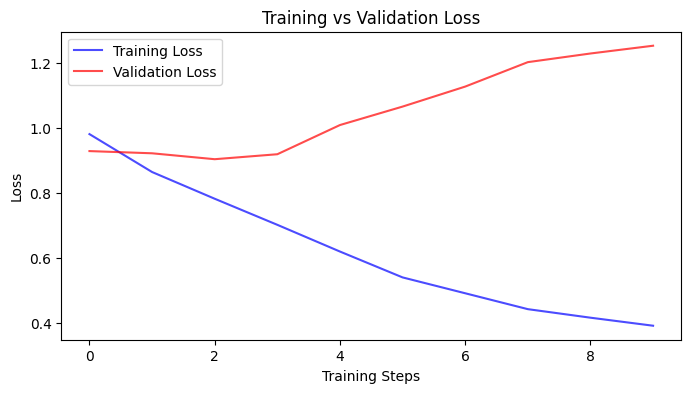

In [183]:
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss", color="blue", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", color="red", alpha=0.7)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [184]:
# Load model
model_name = "epoch_9"
model = AutoModelForSequenceClassification.from_pretrained(MODELS_PATH + model_name)
# model = CustomBERTModel(MODEL_NAME, NUM_CLASSES)
# model.load_state_dict(torch.load(MODELS_PATH + model_name + ".pt"))

model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Validation Evaluation

In [185]:
model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs

        y_pred_val.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        y_true_val.extend(batch["labels"].cpu().tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)

print(classification_report(y_true_val, y_pred_val, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.57      0.67      0.61       244
         NEU       0.71      0.54      0.61       406
         POS       0.26      0.45      0.33        71

    accuracy                           0.57       721
   macro avg       0.51      0.55      0.52       721
weighted avg       0.62      0.57      0.58       721



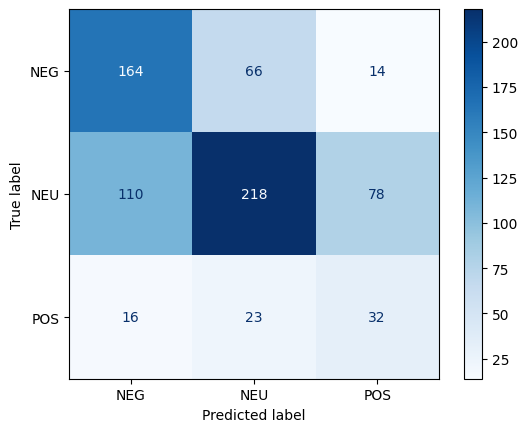

In [186]:
# Confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)

### Test Evaluation

In [187]:
model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        y_pred_test.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        y_true_test.extend(batch["labels"].cpu().tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

print(classification_report(y_true_test, y_pred_test, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.53      0.66      0.59       487
         NEU       0.72      0.56      0.63       812
         POS       0.30      0.45      0.36       143

    accuracy                           0.58      1442
   macro avg       0.52      0.55      0.52      1442
weighted avg       0.62      0.58      0.59      1442



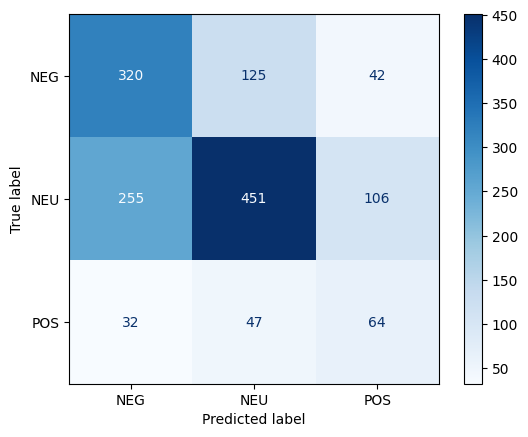

In [188]:
# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)

### Train results

In [189]:
model.eval()

y_pred_train = []
y_true_train = []
with torch.no_grad(): 
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        y_pred_train.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        y_true_train.extend(batch["labels"].cpu().tolist())

y_pred_train = np.array(y_pred_train)
y_true_train = np.array(y_true_train)

print(classification_report(y_true_train, y_pred_train, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.74      0.90      0.81      1703
         NEU       0.93      0.73      0.82      2842
         POS       0.68      0.99      0.80       499

    accuracy                           0.81      5044
   macro avg       0.78      0.87      0.81      5044
weighted avg       0.84      0.81      0.81      5044



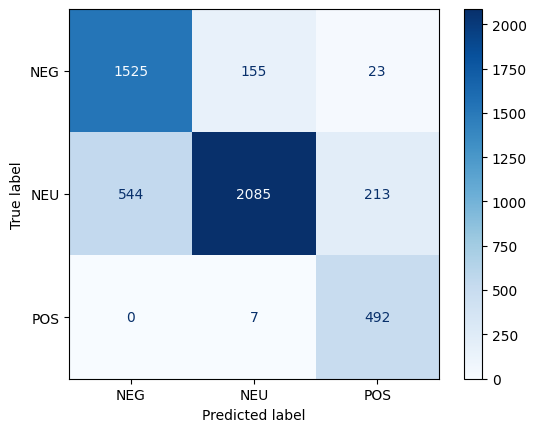

In [190]:
# Confusion matrix
cm = confusion_matrix(y_true_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)

## Predictions

In [191]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODELS_PATH + model_name)
# model = CustomBERTModel(MODEL_NAME, NUM_CLASSES)
# model.load_state_dict(torch.load(MODELS_PATH + model_name + ".pt"))
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [192]:
mapping = {0: 'NEG', 1: 'NEU', 2: 'POS'}

In [193]:
# Predict test sample
def predict_sample(model, tokenizer, sample_text):
    """
    Predict the sentiment of a sample text
    """
    inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    inputs["labels"] = None

    with torch.no_grad():
        outputs = model(**inputs)
        try:
            logits = outputs.logits
        except:
            logits = outputs
    
    probabilities = torch.softmax(logits, dim=-1)
    
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    predicted_label = mapping[predicted_class]
    
    return predicted_label, probabilities[0].cpu().numpy()

In [194]:
# test_idx = 40
test_idx = 2

text_col = "text"
input_text = test_df[text_col][test_idx]

# Get paraphrased samples
samples = ast.literal_eval(test_df[paraphrase_col][test_idx])
samples=list(samples)
paraphrase_text1 = samples[0]
paraphrase_text2 = samples[1]

real_label = test_df['label'][test_idx]
real_label = mapping[real_label]
print("Input text:", input_text)
print("Real label:", real_label)
print("Paraphrase 1:", paraphrase_text1)
print("Paraphrase 2:", paraphrase_text2)
print()

predicted_label, probabilities = predict_sample(model, tokenizer, input_text)
print("Predicted label:", predicted_label)
print("Probabilities:", probabilities)
print()

predicted_label1, probabilities = predict_sample(model, tokenizer, paraphrase_text1)
print("Predicted label para1:", predicted_label1)
print("Probabilities:", probabilities)
print()

predicted_label2, probabilities = predict_sample(model, tokenizer, paraphrase_text2)
print("Predicted label para2:", predicted_label2)
print("Probabilities:", probabilities)
print()

predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)
print("Final predicted label:", predicted_label)


Input text: now i am opening up to going out on dates to find someone to be with, to support each other, to care for each other, to do romantic things, and to have a good time. i like to believe that one wants to be in a couple for more than just casual sex in general, not just as an 'asexual' person.
Real label: NEU
Paraphrase 1: i'm starting to be open to dating to discover someone to share my life with, to provide support for each other, to show care, to enjoy romantic moments, and to have fun together. i like to think that people seek a relationship for reasons beyond just casual sex, not limited to being an 'asexual' person.
Paraphrase 2: i'm beginning to embrace the idea of going on dates to find someone with whom i can share life experiences, support one another, express care, engage in romantic activities, and have enjoyable moments. i like to believe that individuals look for a partnership for various reasons, extending beyond mere casual sex, not just as an 'asexual' person.


### Normal predictions

              precision    recall  f1-score   support

         NEG       0.53      0.66      0.59       487
         NEU       0.72      0.56      0.63       812
         POS       0.30      0.45      0.36       143

    accuracy                           0.58      1442
   macro avg       0.52      0.55      0.52      1442
weighted avg       0.62      0.58      0.59      1442



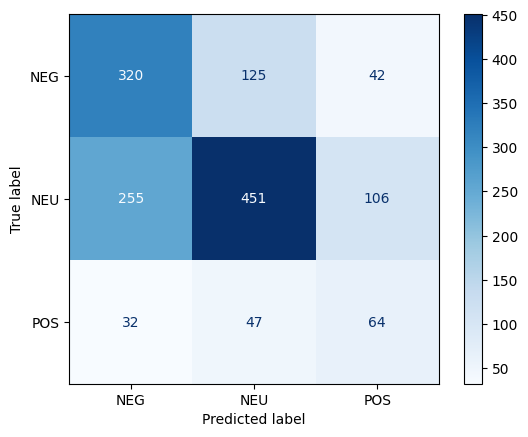

In [195]:
y_pred_test = []
y_true_test = []

for i in range(len(test_df)):
    input_text = test_df[text_col][i]

    real_label = test_df['label'][i]
    real_label = mapping[real_label]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text)

    y_pred_test.append(predicted_label)
    y_true_test.append(real_label)

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

print(classification_report(y_true_test, y_pred_test, target_names=id2label.values()))
# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)

### Ensemble predicions

              precision    recall  f1-score   support

         NEG       0.56      0.66      0.61       487
         NEU       0.75      0.59      0.66       812
         POS       0.34      0.54      0.42       143

    accuracy                           0.61      1442
   macro avg       0.55      0.60      0.56      1442
weighted avg       0.64      0.61      0.62      1442



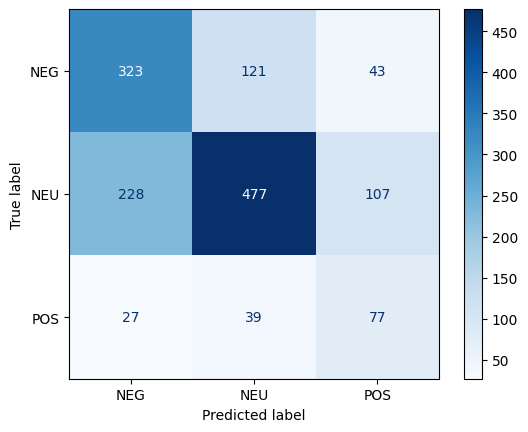

In [196]:
y_pred_test = []
y_true_test = []

for i in range(len(test_df)):
    input_text = test_df[text_col][i]
    
    # Get paraphrased samples
    samples = ast.literal_eval(test_df[paraphrase_col][i])
    samples=list(samples)
    paraphrase_text1 = samples[0]
    paraphrase_text2 = samples[1]

    real_label = test_df['label'][i]
    real_label = mapping[real_label]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text)
    predicted_label1, probabilities1 = predict_sample(model, tokenizer, paraphrase_text1)
    predicted_label2, probabilities2 = predict_sample(model, tokenizer, paraphrase_text2)

    if predicted_label != predicted_label1 and predicted_label != predicted_label2 and predicted_label1 != predicted_label2:
        labels = [predicted_label, predicted_label1, predicted_label2]
        label1_score = max(probabilities)
        label2_score = max(probabilities1)
        label3_score = max(probabilities2)
        scores = {label1_score: predicted_label, label2_score: predicted_label1, label3_score: predicted_label2}
        final_label = max(scores.keys())
        predicted_label = scores[final_label]
    else:
        # Get the most frequent label
        predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)
    y_pred_test.append(predicted_label)
    y_true_test.append(real_label)

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

print(classification_report(y_true_test, y_pred_test, target_names=id2label.values()))
# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)